<a href="https://colab.research.google.com/github/lotrmay/TensorFlow_Learning/blob/master/bc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(15958, 98)
(2817, 98)
(15800, 98) (15800, 98)
Epoch 1/1000
247/247 [==============================] - 2s 3ms/step - loss: 0.6946 - accuracy: 0.4780 - val_loss: 0.6899 - val_accuracy: 0.5360
Epoch 2/1000
247/247 [==============================] - 0s 2ms/step - loss: 0.6896 - accuracy: 0.5367 - val_loss: 0.6888 - val_accuracy: 0.5364
Epoch 3/1000
247/247 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5383 - val_loss: 0.6879 - val_accuracy: 0.5364
Epoch 4/1000
247/247 [==============================] - 0s 2ms/step - loss: 0.6869 - accuracy: 0.5418 - val_loss: 0.6872 - val_accuracy: 0.5364
Epoch 5/1000
247/247 [==============================] - 1s 2ms/step - loss: 0.6863 - accuracy: 0.5401 - val_loss: 0.6864 - val_accuracy: 0.5367
Epoch 6/1000
247/247 [==============================] - 1s 2ms/step - loss: 0.6860 - accuracy: 0.5361 - val_loss: 0.6848 - val_accuracy: 0.5367
Epoch 7/1000
247/247 [==============================] - 0s 2ms/step - loss: 0.6842 - accu

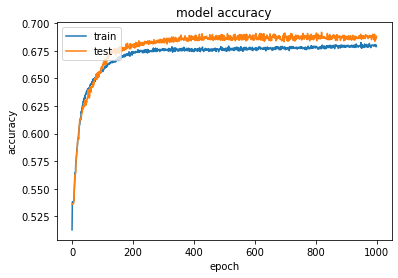

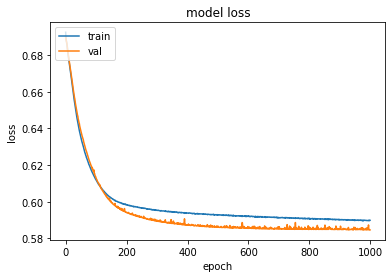

In [48]:
%tensorflow_version 2.x
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import numpy as np #better arrays in python, lepší práce s multidimenzionálními poli
import pandas as pd #data analytics tool, lepší manipulace s daty, dokáže například cut outnout column
import matplotlib.pyplot as plt #vizualizace tabulek a grafů
from IPython.display import clear_output #jen pro tenhle notebook
from six.moves import urllib
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import utils as np_utils
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import numpy
import keras
CSV_COLUMN_NAMES=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg','Match_link','Result','team_one_name','team_two_name']
RESULTS=['0','1']


train=pd.read_csv('/content/pokus.csv',sep=";",names=CSV_COLUMN_NAMES,error_bad_lines=False,header=None)
#train_y=train.pop('Result')
#test_y=test.pop('Result')
train.pop('Match_link')
train.pop('team_one_name')
train.pop('team_two_name')
'''
train.pop('playerAAGrenadeDmg')
train.pop('playerABGrenadeDmg')
train.pop('playerACGrenadeDmg')
train.pop('playerADGrenadeDmg')
train.pop('playerAEGrenadeDmg')
train.pop('playerBAGrenadeDmg')
train.pop('playerBBGrenadeDmg')
train.pop('playerBCGrenadeDmg')
train.pop('playerBDGrenadeDmg')
train.pop('playerBEGrenadeDmg')

train.pop('playerAAKast')
train.pop('playerABKast')
train.pop('playerACKast')
train.pop('playerADKast')
train.pop('playerAEKast')
train.pop('playerBAKast')
train.pop('playerBBKast')
train.pop('playerBCKast')
train.pop('playerBDKast')
train.pop('playerBEKast')

train.pop('playerAAKD')
train.pop('playerABKD')
train.pop('playerACKD')
train.pop('playerADKD')
train.pop('playerAEKD')
train.pop('playerBAKD')
train.pop('playerBBKD')
train.pop('playerBCKD')
train.pop('playerBDKD')
train.pop('playerBEKD')
'''

target_column = ['Result'] 
predictors = list(set(list(train.columns))-set(target_column))
scaler = MinMaxScaler(feature_range=(0.01, 0.99))
norm = StandardScaler()
train[predictors]=norm.fit_transform(train[predictors])
train[predictors] = scaler.fit_transform(train[predictors])


#train[predictors] = train[predictors]/train[predictors].max()

X = train[predictors].values
y = train[target_column].values
#print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=9)#32 #888
print(X_train.shape); print(X_test.shape)
#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)#tohle nepoužívám, protože mám sigmoid a výsledky můžou být jen 1 nebo 0, takže to není nutné dělat  z toho kategorizační vektory
count_classes = y_test.shape[1]


model = Sequential()
model.add(Dense(98, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))#binary sigmoid     categorical softmax


model.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.017), #keras.optimizers.SGD(learning_rate=0.01)
              loss='binary_crossentropy', 
              metrics=['accuracy'])
#change number of hidden layers and change the learning rate up to 0.9

#adadelta-lr 0.04 78 (bez grenadedmg a kast) 20 4 1 sigmoid binary crossentropy  1000 epochs a 64 batch size a 9 rs
#adadelta-lr 0.015 98 30 15 5 2 rs9 testsize 0.15 64batchsize  Accuracy on test data: 0.690095841884613% 
#adadelta-lr 0.02 98 35 15 2 rs17 testsize 0.15 64batchsize 0.15 test rate Accuracy on test data: 0.6890308856964111% 
#record accuracy má Adadelta(0.01), categorical_crossentropy 98,50,2 1000 epochs a 32 batch size
#record accuracy má adadelta(0.01) 86 random state 32 batch size a 1000 epochs  test accuracy: 0.674478
#adadelta zatím top
#binary_crossentropy
#categorical_crossentropy
# categorical_hinge 0.677
# hinge 0.667
# MeanAbsoluteError 0.654, 
# MeanAbsolutePercentageError 0.6814 

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
print(X_train.shape, X_train.shape)
history = model.fit(X_train, y_train, epochs=1000,batch_size=64,validation_data=(X_test, y_test))

pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
pred_test= model.predict(X_test)



scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#poznatky-vypadá to, že grenade damage každého hráče je nadbytečná a síť bez této informace vykazuje lepší výsledky

In [47]:
Xnew=np.array([[1.8,1.9,26,23,0.63,0.64,0.509,0.591,1.16,0.68,0.7,1.26,84.3,0.75,0.5,1.11,7.4,1.13,0.64,0.72,1.11,78.0,0.72,0.57,1.13,3.2,1.0,0.67,0.69,0.95,69.3,0.64,0.58,0.95,4.2,0.99,0.65,0.69,0.95,67.7,0.62,0.58,0.94,3.3,1.07,0.66,0.7,1.0675000000000001,74.825,0.6825,0.5575,1.0325000000000002,4.525,1.23,0.6,0.75,1.26,79.4,0.77,0.31,1.29,3.4,1.24,0.61,0.77,1.15,82.8,0.82,0.52,1.35,3.4,1.14,0.62,0.73,1.11,76.1,0.72,0.5,1.16,5.2,1.0,0.68,0.7,0.98,70.2,0.61,0.51,0.90,3.9,0.98,0.69,0.69,0.96,71.7,0.6,0.48,0.87,5.3],
                [1.43,2.5,21,40,0.7,0.56,0.532,0.5,1.18,0.6,0.74,1.16,78.1,0.74,0.57,1.24,3.8,1.17,0.62,0.71,1.2,78.5,0.77,0.28,1.23,3.0,1.1,0.63,0.72,1.09,75.8,0.71,0.56,1.12,4.0,1.08,0.67,0.71,1.12,76.3,0.68,0.58,1.02,5.0,0.99,0.68,0.69,0.98,72.7,0.61,0.5,0.90,6.7,1.1,0.67,0.71,1.14,77.6,0.71,0.53,1.05,6.0,1.06,0.67,0.72,0.99,76.3,0.69,0.52,1.03,4.7,1.02,0.7,0.72,0.97,74.1,0.66,0.52,0.95,4.5,0.97,0.72,0.69,0.99,73.5,0.6,0.42,0.83,7.2,1.0375,0.69,0.71,1.0225,75.375,0.665,0.4975,0.9650000000000001,5.6],
                [1.8,1.9,29,59,0.53,0.57,0.519,0.5,1.11,0.65,0.7,1.13,77.9,0.72,0.57,1.11,6.2,1.06,0.67,0.72,0.99,74.7,0.67,0.53,1.00,3.6,1.06,0.68,0.71,1.06,76.8,0.68,0.49,1.00,6.3,1.05,0.68,0.7,1.08,72.9,0.67,0.39,0.99,5.0,0.93,0.69,0.69,0.82,68.8,0.59,0.53,0.86,5.5,1.34,0.61,0.74,1.34,90.6,0.9,0.41,1.47,3.9,1.08,0.62,0.75,0.89,72.9,0.66,0.6,1.07,4.2,1.08,0.67,0.71,1.19,73.4,0.66,0.49,0.99,10.7,0.99,0.67,0.72,0.8,71.4,0.63,0.52,0.93,5.6,0.95,0.62,0.68,0.79,60.9,0.58,0.4,0.93,3.0],
                [1.45,2.5,32,54,0.62,0.27,0.452,0.5,1.28,0.59,0.78,1.22,88.5,0.8,0.5,1.35,7.9,1.16,0.62,0.72,1.17,78.4,0.74,0.24,1.19,4.4,1.07,0.67,0.73,1.05,76.2,0.65,0.42,0.97,5.5,1.05,0.64,0.73,0.99,70.3,0.64,0.51,1.01,5.3,1.05,0.65,0.72,1.05,70.2,0.66,0.43,1.02,4.1,1.1,0.69,0.71,1.07,83.1,0.72,0.49,1.05,7.7,1.06,0.74,0.66,1.28,78.5,0.71,0.52,0.96,4.3,0.97,0.66,0.72,0.85,68.6,0.59,0.52,0.89,3.7,0.94,0.66,0.69,0.92,63.5,0.59,0.36,0.88,3.5,0.88,0.73,0.68,0.84,64.6,0.56,0.56,0.77,4.2],
                [1.5,2.5,36,44,0.55,0.57,0.529,0.5,1.13,0.63,0.7,1.18,75.6,0.75,0.27,1.19,2.4,1.13,0.59,0.73,1.03,78.6,0.69,0.38,1.17,5.8,1.07,0.71,0.67,1.17,78.9,0.73,0.47,1.03,3.7,0.96,0.68,0.69,0.87,70.0,0.61,0.52,0.90,5.6,0.94,0.67,0.67,0.95,65.1,0.59,0.57,0.88,4.0,1.23,0.59,0.74,1.25,79.8,0.79,0.38,1.34,2.6,1.09,0.64,0.73,0.97,79.2,0.7,0.49,1.09,4.9,1.06,0.67,0.7,1.05,76.1,0.67,0.54,0.99,4.2,1.1266666666666667,0.6333333333333333,0.7233333333333333,1.0899999999999999,78.36666666666666,0.7200000000000001,0.47000000000000003,1.14,3.9,1.1266666666666667,0.6333333333333333,0.7233333333333333,1.0899999999999999,78.36666666666666,0.7200000000000001,0.47000000000000003,1.14,3.9]
               ,[1.25,3.75,25,146,0.58,0.64,0.537,0.5,1.12,0.63,0.7,1.18,74.8,0.72,0.3,1.13,5.8,1.11,0.61,0.74,0.98,76.4,0.68,0.43,1.12,7.8,1.08,0.69,0.7,1.13,78.6,0.69,0.58,1.00,7.6,1.03,0.67,0.69,1.05,73.4,0.66,0.6,0.97,5.7,1.02,0.63,0.7,0.95,69.1,0.63,0.55,1.01,4.3,1.21,0.64,0.74,1.12,86.7,0.82,0.51,1.28,4.4,1.19,0.63,0.74,1.13,84.0,0.76,0.5,1.21,4.7,0.99,0.66,0.68,1.01,68.3,0.64,0.57,0.96,4.2,0.97,0.61,0.68,0.9,64.6,0.59,0.45,0.96,7.1,0.95,0.69,0.67,0.99,66.8,0.6,0.28,0.87,4.3]
               ])
Xnew=norm.fit_transform(Xnew)
Xnew = scaler.fit_transform(Xnew)

ynew=(model.predict([Xnew]))
#ynew=(model.predict_classes([Xnew]))
print(ynew)

Consider rewriting this model with the Functional API.
[[0.04357523]
 [0.04865813]
 [0.11653918]
 [0.10641721]
 [0.10350421]
 [0.9388274 ]]
